### LaBSE + muril

original

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, classification_report

# Load your CSV file
df = pd.read_csv("/kaggle/input/againrest/training_data_telugu-hate.csv")

# Mapping labels to integers
label_map = {'hate': 1, 'non-hate': 0}
df['Label'] = df['Label'].map(label_map)

# Extract input texts and labels
texts = df['Comments'].tolist()
labels = df['Label'].tolist()

# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Load pre-trained LaBSE and MuRIL models and tokenizers
labse_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/LaBSE")
labse_model = AutoModelForSequenceClassification.from_pretrained("sentence-transformers/LaBSE", num_labels=2)

muril_tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")
muril_model = AutoModelForSequenceClassification.from_pretrained("google/muril-base-cased", num_labels=2)

# Tokenize inputs
train_encodings_labse = labse_tokenizer(train_texts, truncation=True, padding=True)
test_encodings_labse = labse_tokenizer(test_texts, truncation=True, padding=True)

train_encodings_muril = muril_tokenizer(train_texts, truncation=True, padding=True)
test_encodings_muril = muril_tokenizer(test_texts, truncation=True, padding=True)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create PyTorch datasets
train_dataset_labse = torch.utils.data.TensorDataset(torch.tensor(train_encodings_labse['input_ids']),
                                                     torch.tensor(train_encodings_labse['attention_mask']),
                                                     train_labels)
test_dataset_labse = torch.utils.data.TensorDataset(torch.tensor(test_encodings_labse['input_ids']),
                                                    torch.tensor(test_encodings_labse['attention_mask']),
                                                    test_labels)

train_dataset_muril = torch.utils.data.TensorDataset(torch.tensor(train_encodings_muril['input_ids']),
                                                     torch.tensor(train_encodings_muril['attention_mask']),
                                                     train_labels)
test_dataset_muril = torch.utils.data.TensorDataset(torch.tensor(test_encodings_muril['input_ids']),
                                                    torch.tensor(test_encodings_muril['attention_mask']),
                                                    test_labels)

# Create data loaders
train_loader_labse = torch.utils.data.DataLoader(train_dataset_labse, batch_size=8, shuffle=True)
test_loader_labse = torch.utils.data.DataLoader(test_dataset_labse, batch_size=8, shuffle=False)

train_loader_muril = torch.utils.data.DataLoader(train_dataset_muril, batch_size=8, shuffle=True)
test_loader_muril = torch.utils.data.DataLoader(test_dataset_muril, batch_size=8, shuffle=False)

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
labse_model.to(device)
muril_model.to(device)

# Set optimizers and learning rate schedulers
optimizer_labse = AdamW(labse_model.parameters(), lr=1e-5)
optimizer_muril = AdamW(muril_model.parameters(), lr=1e-5)
num_epochs = 10

# Training loop for LaBSE
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs} (LaBSE)")
    labse_model.train()
    for batch in train_loader_labse:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer_labse.zero_grad()
        outputs = labse_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer_labse.step()

# Training loop for MuRIL
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs} (MuRIL)")
    muril_model.train()
    for batch in train_loader_muril:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer_muril.zero_grad()
        outputs = muril_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer_muril.step()

# Evaluation
labse_model.eval()
muril_model.eval()
predictions_labse = []
predictions_muril = []
true_labels = []
for batch in test_loader_labse:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = labse_model(input_ids, attention_mask=attention_mask)
    
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    
    predictions_labse.extend(preds.cpu().numpy())

for batch in test_loader_muril:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = muril_model(input_ids, attention_mask=attention_mask)
    
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    
    predictions_muril.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Combine predictions from both models
final_predictions = []
for pred_labse, pred_muril in zip(predictions_labse, predictions_muril):
    # Simple voting scheme, you can choose a different method for combining predictions
    combined_prediction = 1 if (pred_labse + pred_muril) >= 1 else 0
    final_predictions.append(combined_prediction)

# Calculate accuracy and other metrics
accuracy = accuracy_score(true_labels, final_predictions)
report = classification_report(true_labels, final_predictions)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/LaBSE and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 (LaBSE)
Epoch 2/10 (LaBSE)
Epoch 3/10 (LaBSE)
Epoch 4/10 (LaBSE)
Epoch 5/10 (LaBSE)
Epoch 6/10 (LaBSE)
Epoch 7/10 (LaBSE)
Epoch 8/10 (LaBSE)
Epoch 9/10 (LaBSE)
Epoch 10/10 (LaBSE)
Epoch 1/10 (MuRIL)
Epoch 2/10 (MuRIL)
Epoch 3/10 (MuRIL)
Epoch 4/10 (MuRIL)
Epoch 5/10 (MuRIL)
Epoch 6/10 (MuRIL)
Epoch 7/10 (MuRIL)
Epoch 8/10 (MuRIL)
Epoch 9/10 (MuRIL)
Epoch 10/10 (MuRIL)
Accuracy: 0.77125
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.68      0.76       430
           1       0.70      0.88      0.78       370

    accuracy                           0.77       800
   macro avg       0.78      0.78      0.77       800
weighted avg       0.79      0.77      0.77       800



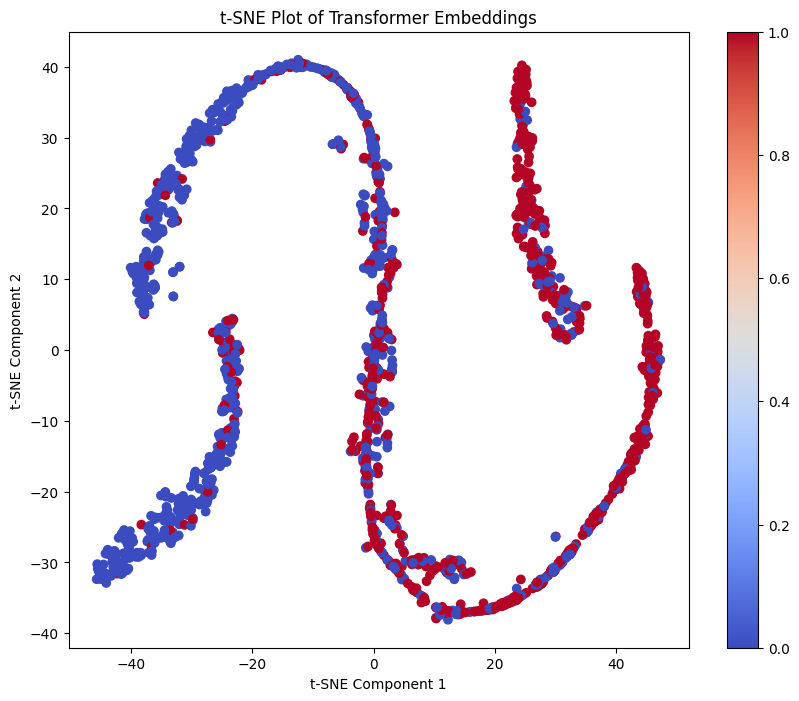

In [9]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Function to get embeddings
def get_embeddings(model, tokenizer, data_loader):
    embeddings = []
    labels = []
    for batch in data_loader:
        input_ids, attention_mask, batch_labels = batch
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
        
        # Extract logits
        logits = outputs.logits
        
        # Convert the tensor to numpy array and append to the list
        embeddings.append(logits.cpu().numpy())
        labels.extend(batch_labels.numpy())
    
    # Concatenate all embeddings into one numpy array
    embeddings = np.concatenate(embeddings)
    return embeddings, labels

# Get embeddings for LaBSE
labse_embeddings, labse_labels = get_embeddings(labse_model, labse_tokenizer, test_loader_labse)

# Get embeddings for MuRIL
muril_embeddings, muril_labels = get_embeddings(muril_model, muril_tokenizer, test_loader_muril)

# Concatenate embeddings and labels
all_embeddings = np.concatenate([labse_embeddings, muril_embeddings])
all_labels = labse_labels + muril_labels

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(all_embeddings)

# Plot t-SNE
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=all_labels, cmap='coolwarm')
plt.title('t-SNE Plot of Transformer Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert predictions and true labels to numpy arrays
true_labels_np = np.array(true_labels)
final_predictions_np = np.array(final_predictions)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(final_predictions_np.reshape(-1, 1))

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_embeddings[:,0], y=tsne_embeddings[:,1], hue=true_labels_np, palette='Set1', legend='full')
plt.title('t-SNE Plot of Combined Predictions')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='True Label', loc='upper right')
plt.grid(True)
plt.show()

# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels_np, final_predictions_np)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['non-hate', 'hate'], yticklabels=['non-hate', 'hate'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


translated

In [3]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, classification_report

# Load your CSV file
df = pd.read_csv('/kaggle/input/telugudat1/Hos_train_translated.csv')

# Mapping labels to integers
label_map = {'hate': 1, 'non-hate': 0}
df['Label'] = df['Label'].map(label_map)

# Extract input texts and labels
texts = df['comments '].tolist()
labels = df['Label'].tolist()

# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Load pre-trained LaBSE and MuRIL models and tokenizers
labse_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/LaBSE")
labse_model = AutoModelForSequenceClassification.from_pretrained("sentence-transformers/LaBSE", num_labels=2)

muril_tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")
muril_model = AutoModelForSequenceClassification.from_pretrained("google/muril-base-cased", num_labels=2)

# Tokenize inputs
train_encodings_labse = labse_tokenizer(train_texts, truncation=True, padding=True)
test_encodings_labse = labse_tokenizer(test_texts, truncation=True, padding=True)

train_encodings_muril = muril_tokenizer(train_texts, truncation=True, padding=True)
test_encodings_muril = muril_tokenizer(test_texts, truncation=True, padding=True)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create PyTorch datasets
train_dataset_labse = torch.utils.data.TensorDataset(torch.tensor(train_encodings_labse['input_ids']),
                                                     torch.tensor(train_encodings_labse['attention_mask']),
                                                     train_labels)
test_dataset_labse = torch.utils.data.TensorDataset(torch.tensor(test_encodings_labse['input_ids']),
                                                    torch.tensor(test_encodings_labse['attention_mask']),
                                                    test_labels)

train_dataset_muril = torch.utils.data.TensorDataset(torch.tensor(train_encodings_muril['input_ids']),
                                                     torch.tensor(train_encodings_muril['attention_mask']),
                                                     train_labels)
test_dataset_muril = torch.utils.data.TensorDataset(torch.tensor(test_encodings_muril['input_ids']),
                                                    torch.tensor(test_encodings_muril['attention_mask']),
                                                    test_labels)

# Create data loaders
train_loader_labse = torch.utils.data.DataLoader(train_dataset_labse, batch_size=8, shuffle=True)
test_loader_labse = torch.utils.data.DataLoader(test_dataset_labse, batch_size=8, shuffle=False)

train_loader_muril = torch.utils.data.DataLoader(train_dataset_muril, batch_size=8, shuffle=True)
test_loader_muril = torch.utils.data.DataLoader(test_dataset_muril, batch_size=8, shuffle=False)

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
labse_model.to(device)
muril_model.to(device)

# Set optimizers and learning rate schedulers
optimizer_labse = AdamW(labse_model.parameters(), lr=1e-5)
optimizer_muril = AdamW(muril_model.parameters(), lr=1e-5)
num_epochs = 10

# Training loop for LaBSE
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs} (LaBSE)")
    labse_model.train()
    for batch in train_loader_labse:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer_labse.zero_grad()
        outputs = labse_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer_labse.step()

# Training loop for MuRIL
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs} (MuRIL)")
    muril_model.train()
    for batch in train_loader_muril:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer_muril.zero_grad()
        outputs = muril_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer_muril.step()

# Evaluation
labse_model.eval()
muril_model.eval()
predictions_labse = []
predictions_muril = []
true_labels = []
for batch in test_loader_labse:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = labse_model(input_ids, attention_mask=attention_mask)
    
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    
    predictions_labse.extend(preds.cpu().numpy())

for batch in test_loader_muril:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = muril_model(input_ids, attention_mask=attention_mask)
    
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    
    predictions_muril.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Combine predictions from both models
final_predictions = []
for pred_labse, pred_muril in zip(predictions_labse, predictions_muril):
    # Simple voting scheme, you can choose a different method for combining predictions
    combined_prediction = 1 if (pred_labse + pred_muril) >= 1 else 0
    final_predictions.append(combined_prediction)

# Calculate accuracy and other metrics
accuracy = accuracy_score(true_labels, final_predictions)
report = classification_report(true_labels, final_predictions)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/LaBSE and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 (LaBSE)
Epoch 2/10 (LaBSE)
Epoch 3/10 (LaBSE)
Epoch 4/10 (LaBSE)
Epoch 5/10 (LaBSE)
Epoch 6/10 (LaBSE)
Epoch 7/10 (LaBSE)
Epoch 8/10 (LaBSE)
Epoch 9/10 (LaBSE)
Epoch 10/10 (LaBSE)
Epoch 1/10 (MuRIL)
Epoch 2/10 (MuRIL)
Epoch 3/10 (MuRIL)
Epoch 4/10 (MuRIL)
Epoch 5/10 (MuRIL)
Epoch 6/10 (MuRIL)
Epoch 7/10 (MuRIL)
Epoch 8/10 (MuRIL)
Epoch 9/10 (MuRIL)
Epoch 10/10 (MuRIL)
Accuracy: 0.74875
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       430
           1       0.72      0.76      0.74       370

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.75       800
weighted avg       0.75      0.75      0.75       800



transliterated

In [4]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, classification_report

# Load your CSV file
df = pd.read_csv('/kaggle/input/telugudat1/transliteration_4000.csv')

# Mapping labels to integers
label_map = {'hate': 1, 'non-hate': 0}
df['Label'] = df['Label'].map(label_map)

# Extract input texts and labels
texts = df['Comments'].tolist()
labels = df['Label'].tolist()

# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Load pre-trained LaBSE and MuRIL models and tokenizers
labse_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/LaBSE")
labse_model = AutoModelForSequenceClassification.from_pretrained("sentence-transformers/LaBSE", num_labels=2)

muril_tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")
muril_model = AutoModelForSequenceClassification.from_pretrained("google/muril-base-cased", num_labels=2)

# Tokenize inputs
train_encodings_labse = labse_tokenizer(train_texts, truncation=True, padding=True)
test_encodings_labse = labse_tokenizer(test_texts, truncation=True, padding=True)

train_encodings_muril = muril_tokenizer(train_texts, truncation=True, padding=True)
test_encodings_muril = muril_tokenizer(test_texts, truncation=True, padding=True)

# Convert labels to PyTorch tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create PyTorch datasets
train_dataset_labse = torch.utils.data.TensorDataset(torch.tensor(train_encodings_labse['input_ids']),
                                                     torch.tensor(train_encodings_labse['attention_mask']),
                                                     train_labels)
test_dataset_labse = torch.utils.data.TensorDataset(torch.tensor(test_encodings_labse['input_ids']),
                                                    torch.tensor(test_encodings_labse['attention_mask']),
                                                    test_labels)

train_dataset_muril = torch.utils.data.TensorDataset(torch.tensor(train_encodings_muril['input_ids']),
                                                     torch.tensor(train_encodings_muril['attention_mask']),
                                                     train_labels)
test_dataset_muril = torch.utils.data.TensorDataset(torch.tensor(test_encodings_muril['input_ids']),
                                                    torch.tensor(test_encodings_muril['attention_mask']),
                                                    test_labels)

# Create data loaders
train_loader_labse = torch.utils.data.DataLoader(train_dataset_labse, batch_size=8, shuffle=True)
test_loader_labse = torch.utils.data.DataLoader(test_dataset_labse, batch_size=8, shuffle=False)

train_loader_muril = torch.utils.data.DataLoader(train_dataset_muril, batch_size=8, shuffle=True)
test_loader_muril = torch.utils.data.DataLoader(test_dataset_muril, batch_size=8, shuffle=False)

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
labse_model.to(device)
muril_model.to(device)

# Set optimizers and learning rate schedulers
optimizer_labse = AdamW(labse_model.parameters(), lr=1e-5)
optimizer_muril = AdamW(muril_model.parameters(), lr=1e-5)
num_epochs = 10

# Training loop for LaBSE
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs} (LaBSE)")
    labse_model.train()
    for batch in train_loader_labse:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer_labse.zero_grad()
        outputs = labse_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer_labse.step()

# Training loop for MuRIL
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs} (MuRIL)")
    muril_model.train()
    for batch in train_loader_muril:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer_muril.zero_grad()
        outputs = muril_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer_muril.step()

# Evaluation
labse_model.eval()
muril_model.eval()
predictions_labse = []
predictions_muril = []
true_labels = []
for batch in test_loader_labse:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = labse_model(input_ids, attention_mask=attention_mask)
    
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    
    predictions_labse.extend(preds.cpu().numpy())

for batch in test_loader_muril:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = muril_model(input_ids, attention_mask=attention_mask)
    
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)
    
    predictions_muril.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Combine predictions from both models
final_predictions = []
for pred_labse, pred_muril in zip(predictions_labse, predictions_muril):
    # Simple voting scheme, you can choose a different method for combining predictions
    combined_prediction = 1 if (pred_labse + pred_muril) >= 1 else 0
    final_predictions.append(combined_prediction)

# Calculate accuracy and other metrics
accuracy = accuracy_score(true_labels, final_predictions)
report = classification_report(true_labels, final_predictions)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/LaBSE and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 (LaBSE)
Epoch 2/10 (LaBSE)
Epoch 3/10 (LaBSE)
Epoch 4/10 (LaBSE)
Epoch 5/10 (LaBSE)
Epoch 6/10 (LaBSE)
Epoch 7/10 (LaBSE)
Epoch 8/10 (LaBSE)
Epoch 9/10 (LaBSE)
Epoch 10/10 (LaBSE)
Epoch 1/10 (MuRIL)
Epoch 2/10 (MuRIL)
Epoch 3/10 (MuRIL)
Epoch 4/10 (MuRIL)
Epoch 5/10 (MuRIL)
Epoch 6/10 (MuRIL)
Epoch 7/10 (MuRIL)
Epoch 8/10 (MuRIL)
Epoch 9/10 (MuRIL)
Epoch 10/10 (MuRIL)
Accuracy: 0.74625
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.76       430
           1       0.71      0.76      0.74       370

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.75       800
weighted avg       0.75      0.75      0.75       800

